In [36]:
import torch
import math
from torch import nn
from torch.utils.data import Dataset
import os
from PIL import Image

In [37]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction='sum')  # Для координат
        self.bce_loss = nn.BCEWithLogitsLoss(reduction='sum')  # Для уверенности

    def forward(self, predictions, targets):
        # Плоское представление для упрощения операций
        # predictions shape: [batch_size, seq_len, 5] 
        # targets shape: [batch_size, seq_len, 1, 5]
        predictions = predictions.view(-1, 5)  # Сглаживаем батч и временные шаги
        targets = targets.view(-1, 5)  # Сглаживаем батч, временные шаги и учитываем, что targets уже содержат 5 значений

        # Предсказанные уверенности и координаты
        pred_confidences = predictions[:, 0]  # Первый столбец - уверенность
        pred_boxes = predictions[:, 1:]  # Остальные столбцы - координаты

        # Целевые уверенности (последний столбец в targets)
        target_confidences = targets[:, 0]  # Используем реальные значения уверенности из targets

        # Целевые координаты
        target_boxes = targets[:, 1:]  # Пропускаем столбец уверенности в targets

        # Расчет потерь
        confidence_loss = self.bce_loss(pred_confidences, target_confidences)
        coordinate_loss = self.mse_loss(pred_boxes, target_boxes)  # Совпадение размеров уже гарантировано

        # Возвращаем сумму потерь
        return confidence_loss + coordinate_loss


In [38]:
# Определение Symmetrical ReLU (SymReLU)
class SymReLU(nn.Module):
    def __init__(self, alpha=1.0):
        super(SymReLU, self).__init__()
        self.alpha = alpha
    
    def forward(self, x):
        return torch.max(x, torch.zeros_like(x)) - self.alpha * torch.min(x, torch.zeros_like(x))

# Определение слоя свертки с SymReLU
class ConvSymRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, groups=1):
        super(ConvSymRelu, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, groups=groups, bias=False)
        self.symrelu = SymReLU(alpha=1.0)
    
    def forward(self, x):
        return self.symrelu(self.conv(x))
    
class ConvBnReLU(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, groups=1):
        super(ConvBnReLU, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, groups=groups, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))
    
class NewYOLOv3(nn.Module):
    def __init__(self, num_classes, lstm_hidden_size=512, lstm_layers=1, seq_len=8):
        super(NewYOLOv3, self).__init__()
        # Определение сверточных слоев
        self.conv0_yolo = ConvBnReLU(3, 12, (5, 5), (1, 1), (2, 2))
        self.maxpool0 = nn.MaxPool2d((2, 2), stride=(2, 2))
        self.conv1 = ConvBnReLU(12, 16, (5, 5), (2, 2), (1, 1))
        self.conv2 = ConvBnReLU(16, 16, (3, 3), (2, 2), (1, 1))
        self.conv3 = ConvBnReLU(16, 16, (3, 3), (1, 1), (1, 1))
        self.pool4 = nn.MaxPool2d((2, 2), stride=(2, 2))
        self.conv5 = ConvBnReLU(16, 24, (3, 3), (1, 1), (1, 1))
        self.conv6 = ConvBnReLU(24, 48, (3, 3), (2, 2), (1, 1))
        self.conv7 = ConvBnReLU(48, 48, (3, 3), (1, 1), (1, 1))
        self.conv8 = ConvBnReLU(48, 48, (3, 3), (1, 1), (1, 1))
        self.conv9 = ConvBnReLU(48, 48, (3, 3), (1, 1), (1, 1))
        self.conv11 = ConvBnReLU(48, 64, (3, 3), (1, 1), (1, 1))
        self.conv13 = ConvBnReLU(64, 64, (7, 7), (7, 7), (0, 0))  # Уменьшаем до 1x1
        self.conv14 = ConvBnReLU(64, 4, (1, 1), (1, 1), (0, 0))  # Меняем количество каналов, сохраняем 1x1
        self.conv14_1 = ConvBnReLU(4, 4, (3, 3), (1, 1), (1, 1))
        self.conv14_2 = ConvBnReLU(4, 4, (3, 3), (1, 1), (1, 1))
        self.upsample0 = nn.Upsample(scale_factor=(1, 1), mode='nearest')
        self.conv15 = ConvBnReLU(4, 96, (3, 3), (1, 1), (1, 1))
        self.prefinal = ConvBnReLU(96, 512, (1, 1), (1, 1), (0, 0))
        self.final = nn.Conv2d(512, 512, (1, 1))
        
        # Определение GRU слоя
        self.gru = nn.GRU(input_size=512, hidden_size=lstm_hidden_size, num_layers=lstm_layers, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_size, 5)
        self.seq_len = seq_len

    def forward(self, x):

        batch_size, seq_len, C, H, W = x.size()
        # Сверточная часть
        x = x.view(batch_size * seq_len, C, H, W)  
        x = self.conv0_yolo(x)
        x = self.maxpool0(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.conv9(x)
        x = self.conv11(x)
        x = self.conv13(x)
        x = self.conv14(x)
        x = self.conv14_1(x)
        x = self.conv14_2(x)
        x = self.upsample0(x)
        x = self.conv15(x)
        x = self.prefinal(x)
        x = self.final(x)
        x = x.view(batch_size, seq_len, -1)  # Подготовка входа для GRU

        # Рекуррентная часть
        hidden = None  # GRU сам инициализирует скрытое состояние, если не задано
        x, hidden = self.gru(x) # возможно надо убрать hidden
        # Применение последнего слоя
        x = self.fc(x)
        return x

In [39]:
class YourDataset(Dataset):
    def __init__(self, img_dir, ann_dir, transform=None):
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.transform = transform

        # Получение списка имен файлов изображений
        self.img_names = [img_name for img_name in os.listdir(img_dir) if img_name.endswith('.jpg')]
        self.img_names.sort(key=lambda x: (x.split('_')[0], int(x.split('_')[2]), int(x.split('_')[3].split('.')[0])))

        # Группировка по видео
        self.grouped_images = {}
        for img_name in self.img_names:
            key = '_'.join(img_name.split('_')[:3])  # a_b_c
            if key not in self.grouped_images:
                self.grouped_images[key] = []
            self.grouped_images[key].append(img_name)

        # Отбрасываем группы, которые не могут полностью сформировать минибатчи
        self.final_img_names = []
        for key, imgs in self.grouped_images.items():
            if len(imgs) >= 8:
                self.final_img_names.extend(imgs[:len(imgs) - (len(imgs) % 8)])

    def __len__(self):
        a = self.final_img_names.__len__() // 8
        
        return a
    
    def print_grouped_images(self):
        for key, images in self.grouped_images.items():
            print(f"{key}: {images}")
            
    def get_final_img_names(self):
        return self.final_img_names

    def __getitem__(self, idx):
        images = []
        annotations = []
        start_index = idx * 8
        for i in range(8):
            img_name = self.final_img_names[start_index + i]
            img_path = os.path.join(self.img_dir, img_name)
            ann_path = os.path.join(self.ann_dir, img_name.replace('.jpg', '.txt'))

            image = Image.open(img_path).convert('RGB')
            ann = self.load_annotations(ann_path)

            if self.transform:
                image = self.transform(image)
            
            images.append(image)
            annotations.append(ann)
            
        images = torch.stack(images)  # Преобразование списка изображений в тензор
        return images, torch.stack(annotations)

    @staticmethod
    def load_annotations(ann_path):
        annotations = []
        with open(ann_path, 'r') as file:
            for line in file:
                _, x_center, y_center, width, height = map(float, line.split())
                annotations.append([1, x_center, y_center, width, height])
        return torch.tensor(annotations)

In [40]:
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.ops import box_iou


In [41]:
# Теперь пути к данным должны указывать на распакованные каталоги
img_dir = '/../kaggle/input/dataset1105/dataset1105/train_images'  # Пример пути к изображениям для обучения
ann_dir = '/../kaggle/input/dataset1105/dataset1105/train_annotations'  # Пример пути к аннотациям для обучения

test_img_dir = '/../kaggle/input/dataset1105/dataset1105/test_images'  # Пример пути к изображениям для тестирования
test_ann_dir = '/../kaggle/input/dataset1105/dataset1105/test_annotations'  # Пример пути к аннотациям для тестирования

In [42]:
batch_size=64
seq_len=8



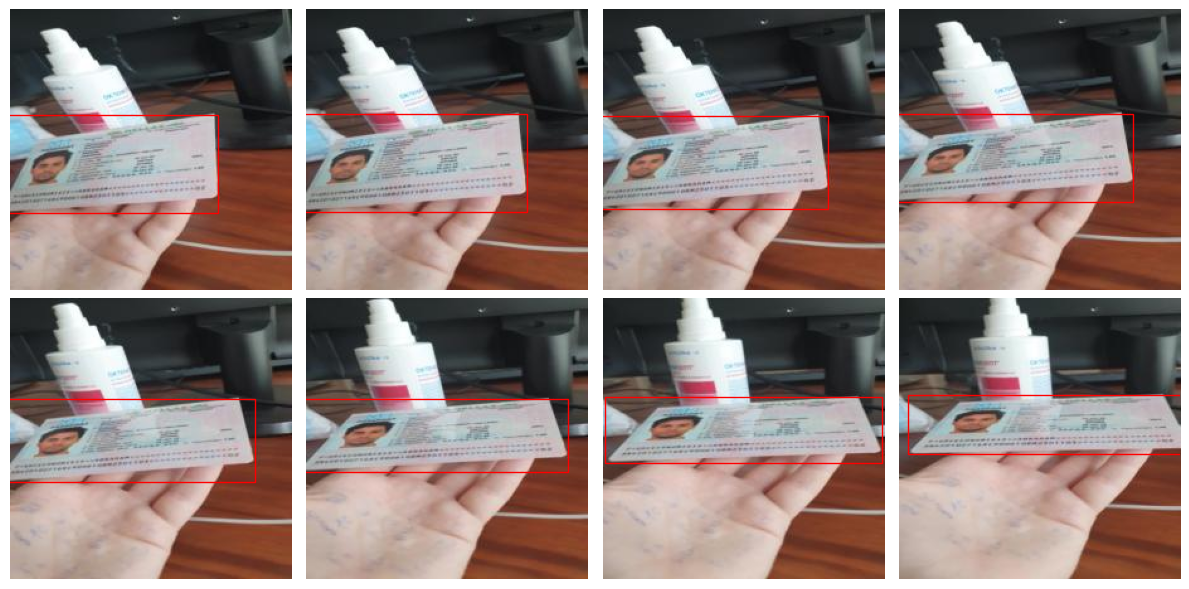

<class 'torch.Tensor'>


In [43]:
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.patches as patches
import matplotlib.pyplot as plt

# Предположим, что YourDataset уже определен как в вашем предыдущем коде


# Определение трансформаций для изображений
transform = transforms.ToTensor()

# Создание экземпляра датасета
dataset = YourDataset(img_dir, ann_dir, transform=transform)

# DataLoader для загрузки данных
loader = DataLoader(dataset, batch_size=1, shuffle=True)

def plot_images(batch_images, batch_annotations):
    """ Функция для отрисовки изображений с bounding boxes. """
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))  # 8 изображений на батч
    axs = axs.flatten()
    
    for i in range(8):  # Перебираем каждое изображение в "мини-батче"
        img = batch_images[0][i].permute(1, 2, 0)  # Перестановка каналов для отображения
        ax = axs[i]
        ax.imshow(img.numpy())
        
        img_height, img_width = img.shape[0], img.shape[1]
        ann = batch_annotations[0][i]  # Аннотации для текущего изображения
        
        # Отображаем каждый bounding box
        for _, x_center, y_center, width, height in ann:
            # Пересчет координат и размеров для масштабирования к размерам изображения
            x = (x_center - width / 2) * img_width
            y = (y_center - height / 2) * img_height
            width = width * img_width
            height = height * img_height
            
            rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Предполагается, что DataLoader уже создан и настроен

for batch_images, batch_annotations in loader:
    plot_images(batch_images, batch_annotations)  # Обработка всего мини-батча
    print(type(batch_annotations))
    break  # Пример с одним батчем для демонстрации


In [44]:
batch_images[0].shape

torch.Size([8, 3, 224, 224])

In [45]:
# Создание экземпляра новой модели
model = NewYOLOv3(num_classes=1)  # Обратите внимание на количество классов

# Проверка доступности CUDA
if torch.cuda.is_available():
    model = model.cuda()

# Создание экземпляра функции потерь и оптимизатора
criterion = CustomLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Подготовка датасетов, загрузчиков и трансформаций, если они нужны
transform = transforms.ToTensor()
  
train_dataset = YourDataset(img_dir, ann_dir, transform=transform)
test_dataset = YourDataset(test_img_dir, test_ann_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)

final_img_names = train_dataset.get_final_img_names()
print(final_img_names.__len__())

41448


In [46]:
def convert_yolo_to_corners(bboxes, img_width, img_height):
    # Предполагаем, что размеры bboxes: [batch_size, seq_len, 5]
    # Первый элемент - confidence, игнорируем его при конвертации координат.

    batch_size, seq_len = bboxes.shape[0], bboxes.shape[1]
    converted_bboxes = []
    for batch in range(batch_size):
        batch_converted_bboxes = []
        for seq in range(seq_len):
            # Берем только координаты x_center, y_center, width, height
            #print(bboxes)
            x_center, y_center, width, height = bboxes[batch, seq, 1:5]
            x_min = (x_center - width / 2) * img_width
            y_min = (y_center - height / 2) * img_height
            x_max = (x_center + width / 2) * img_width
            y_max = (y_center + height / 2) * img_height
            batch_converted_bboxes.append([x_min, y_min, x_max, y_max])
        converted_bboxes.append(batch_converted_bboxes)
    return torch.tensor(converted_bboxes, dtype=torch.float32)


In [47]:
def get_confidence_and_bbox(outputs):
    """
    Разделяет выходные данные модели на уверенности и координаты bounding boxes.

    Параметры:
        outputs (torch.Tensor): Тензор с выходными данными модели размерности [batch_size, 5],
                                где каждая строка содержит [confidence, x, y, width, height].

    Возвращает:
        Tuple[torch.Tensor, torch.Tensor]:
        - Вектор уверенностей размерности [batch_size],
        - Матрицу координат bounding boxes размерности [batch_size, 4].
    """
    # Предполагаем, что outputs уже находится на CPU, если необходимо
    confidences = outputs[:, 0]  # Все строки, первый столбец
    bboxes = outputs[:, 1:]  # Все строки, со второго столбца до последнего

    return confidences, bboxes

In [48]:
def compute_iou_batch(predicted_corners, target_corners):
    # Подготовка тензоров для функции box_iou
    # predicted_corners и target_corners должны иметь форму [batch_size, seq_len, 4]
    batch_size, seq_len, _ = predicted_corners.shape
    ious = torch.zeros(batch_size, seq_len)  # Тензор для хранения значений IoU

    # Вычисляем IoU для каждой пары предсказанных и целевых углов в батче
    for batch in range(batch_size):
        for seq in range(seq_len):
            # Переформатирование тензоров для соблюдения ожидаемой размерности в box_iou
            pred_box = predicted_corners[batch, seq].unsqueeze(0)
            target_box = target_corners[batch, seq].unsqueeze(0)
            iou = box_iou(pred_box, target_box)
            ious[batch, seq] = iou  # Запись результата IoU в тензор

    return ious

In [49]:
def save_checkpoint(state, filename="model_checkpoint.pth"):
    """Сохранение текущего состояния модели"""
    torch.save(state, filename)

def plot_metrics(train_losses, val_losses, train_ious, val_ious, epoch):
    """Отрисовка графиков потерь и IoU"""
    epochs = range(1, epoch + 2)
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_ious, label='Training IoU')
    plt.plot(epochs, val_ious, label='Validation IoU')
    plt.title('Training and Validation IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()

    plt.tight_layout()
    plt.show()


Epoch: 0


epoch 0 L  47.944977 average_iou 0.295708: 100%|██████████| 81/81 [02:29<00:00,  1.84s/it] 


Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] 

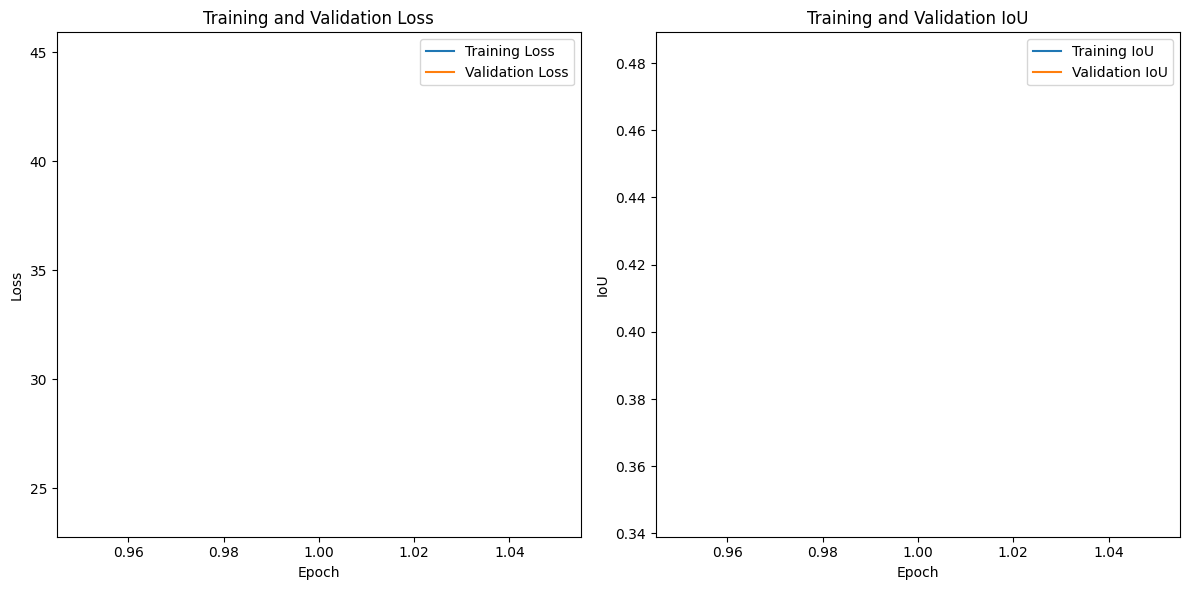

Epoch 1, Train Loss: 44.87224631839328, Train IoU: 0.3458387643604735, Val Loss: 23.817615327380953, Val IoU: 0.4823092293171656
Epoch: 1


epoch 1 L  40.173634 average_iou 0.331390: 100%|██████████| 81/81 [01:56<00:00,  1.44s/it]


Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] 

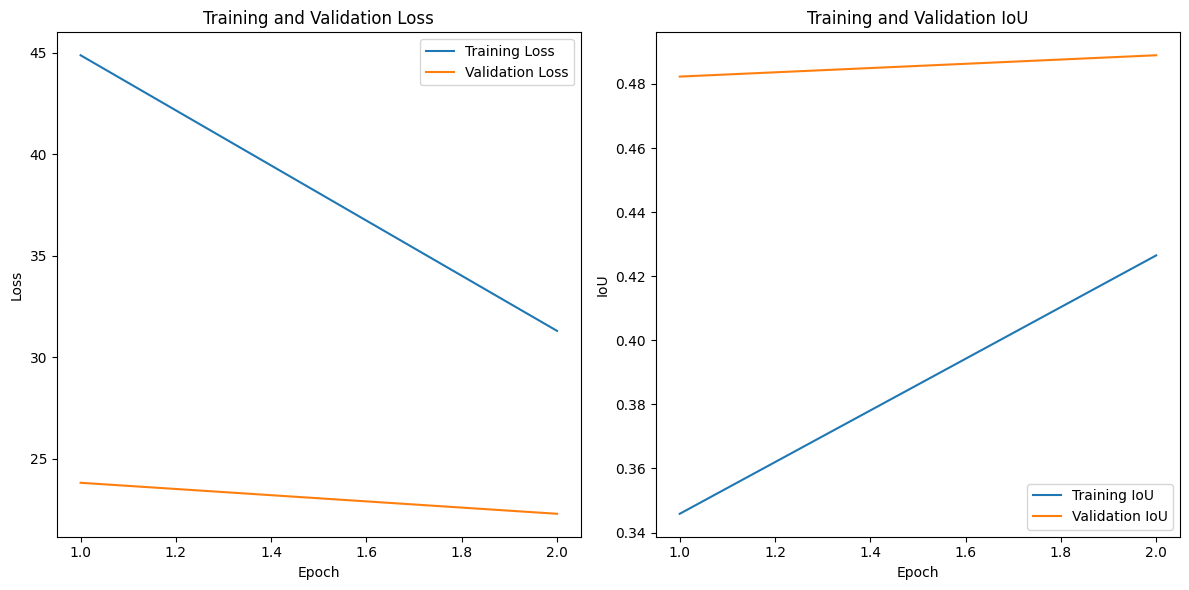

Epoch 2, Train Loss: 31.298405988716784, Train IoU: 0.4264912877553775, Val Loss: 22.290272303989955, Val IoU: 0.4889635741710663
Epoch: 2


epoch 2 L  35.094349 average_iou 0.390355: 100%|██████████| 81/81 [02:00<00:00,  1.49s/it]


Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] 

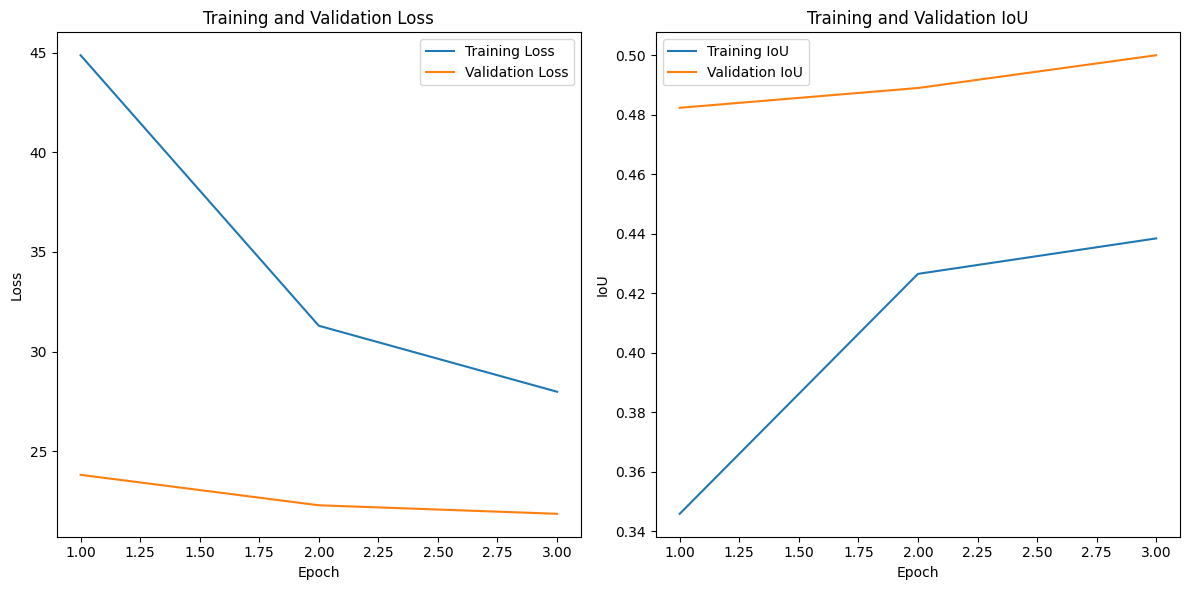

Epoch 3, Train Loss: 27.98751782782284, Train IoU: 0.4384082011234613, Val Loss: 21.862537384033203, Val IoU: 0.49997053969474065
Epoch: 3


epoch 3 L  37.905117 average_iou 0.358221: 100%|██████████| 81/81 [01:58<00:00,  1.46s/it]


Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] 

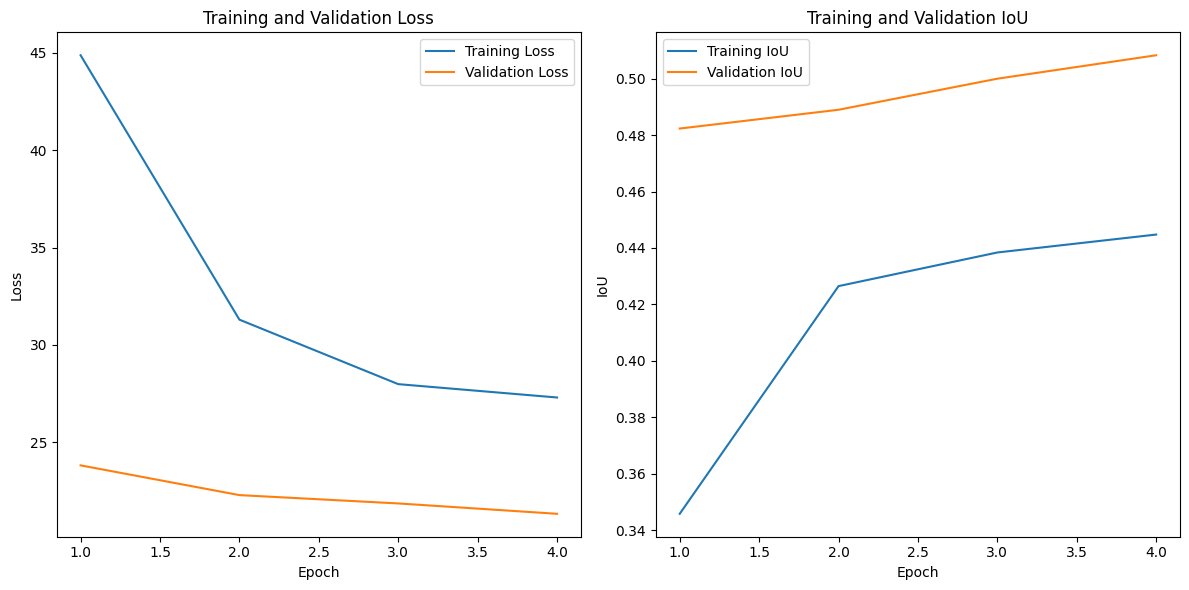

Epoch 4, Train Loss: 27.3018153567373, Train IoU: 0.44475742328314133, Val Loss: 21.33089728582473, Val IoU: 0.5082705077670869
Epoch: 4


epoch 4 L  38.963440 average_iou 0.333587: 100%|██████████| 81/81 [01:58<00:00,  1.46s/it]


Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] 

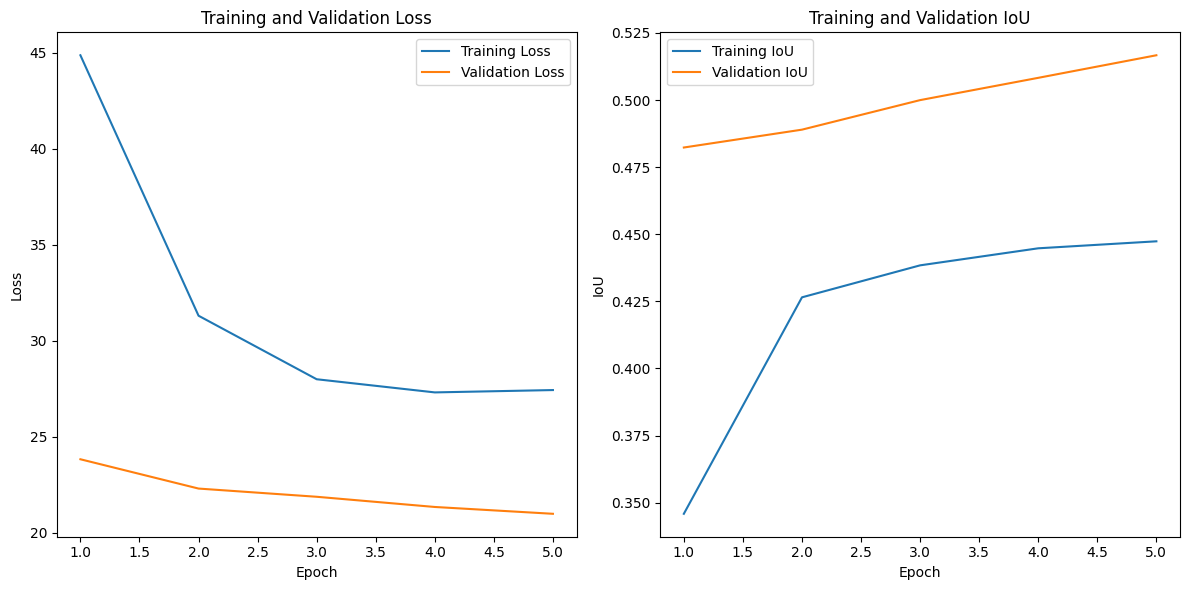

Epoch 5, Train Loss: 27.42395966141312, Train IoU: 0.4473623329842532, Val Loss: 20.975322723388672, Val IoU: 0.516682030189605
Epoch: 5


epoch 5 L  34.174622 average_iou 0.372362: 100%|██████████| 81/81 [01:57<00:00,  1.45s/it]


Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] 

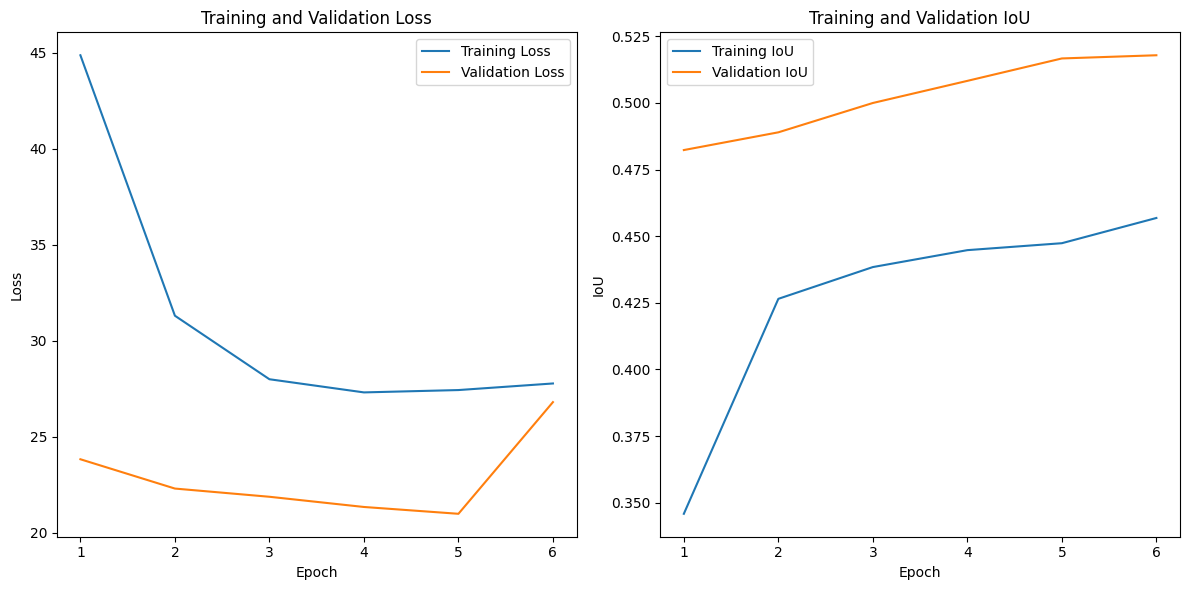

Epoch 6, Train Loss: 27.76726174648897, Train IoU: 0.4568268726637334, Val Loss: 26.795102664402553, Val IoU: 0.5178770976407188
Epoch: 6


epoch 6 L  35.129971 average_iou 0.370586: 100%|██████████| 81/81 [02:08<00:00,  1.59s/it]


Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] 

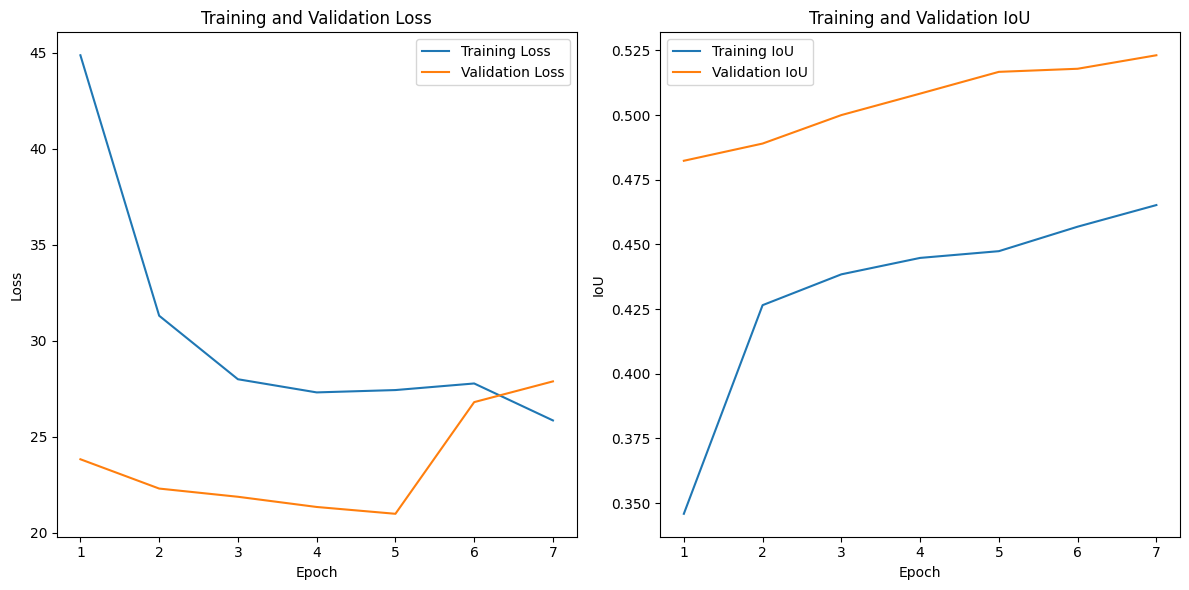

Epoch 7, Train Loss: 25.840956099239396, Train IoU: 0.46518556626490604, Val Loss: 27.876135508219402, Val IoU: 0.5230960973671505
Epoch: 7


epoch 7 L  37.899918 average_iou 0.373156: 100%|██████████| 81/81 [01:59<00:00,  1.47s/it]


Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] 

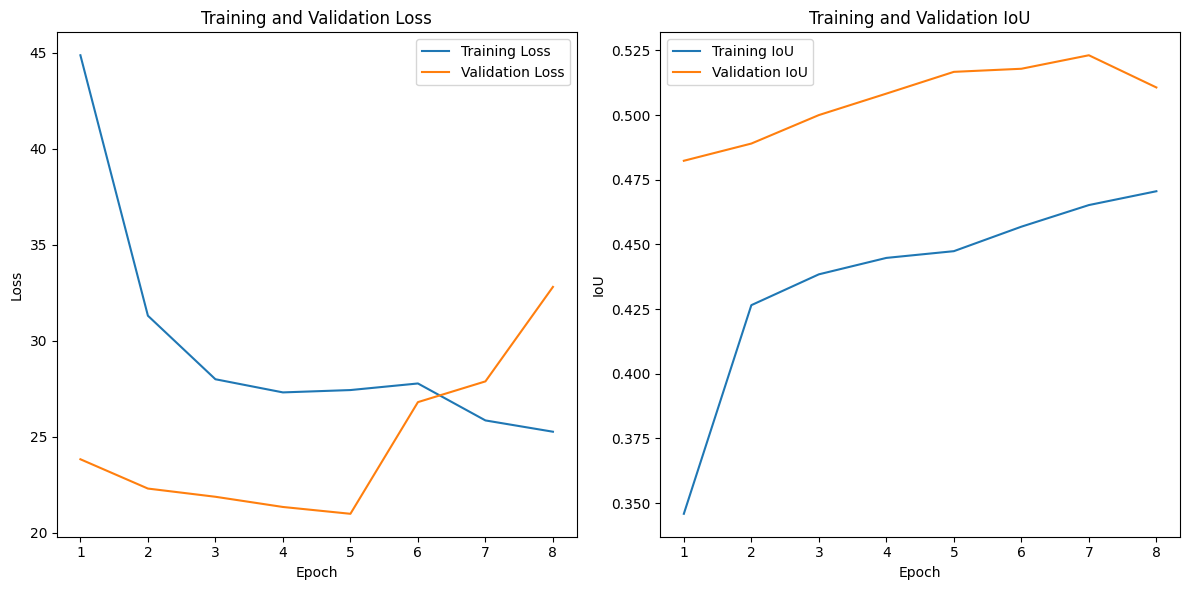

Epoch 8, Train Loss: 25.252514438864626, Train IoU: 0.47053046929247583, Val Loss: 32.799861453828356, Val IoU: 0.5106500869705564
Epoch: 8


epoch 8 L  37.405708 average_iou 0.375125: 100%|██████████| 81/81 [01:54<00:00,  1.41s/it]


Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] 

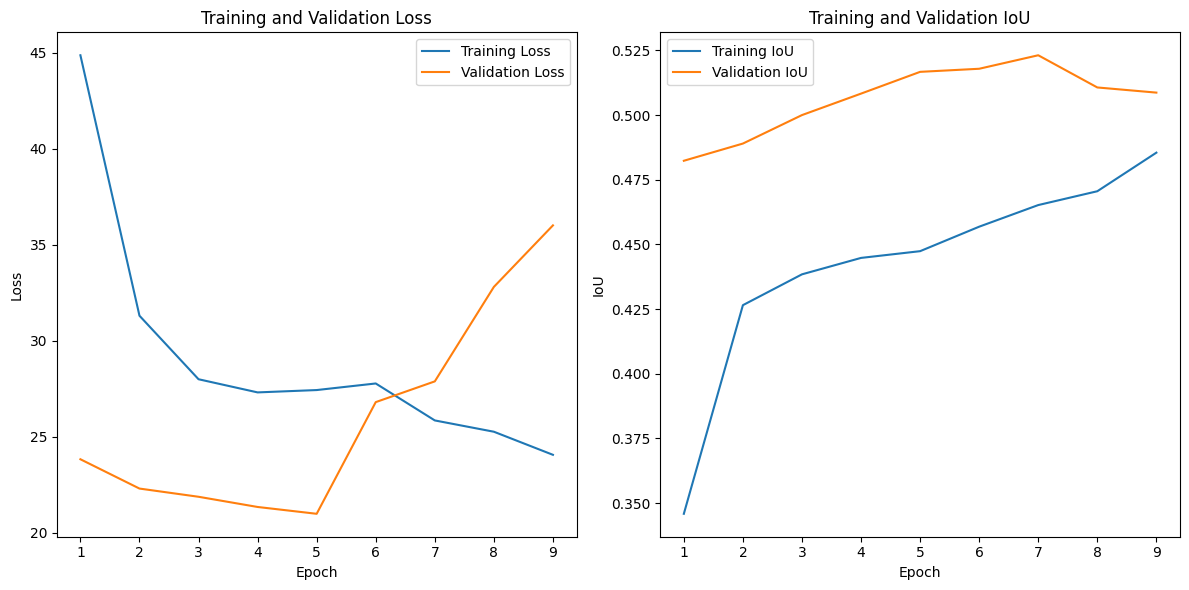

Epoch 9, Train Loss: 24.04916951097088, Train IoU: 0.48544528896425976, Val Loss: 36.00647790091379, Val IoU: 0.5086558305081867
Epoch: 9


epoch 9 L  36.260868 average_iou 0.373080: 100%|██████████| 81/81 [01:53<00:00,  1.40s/it]


Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] 

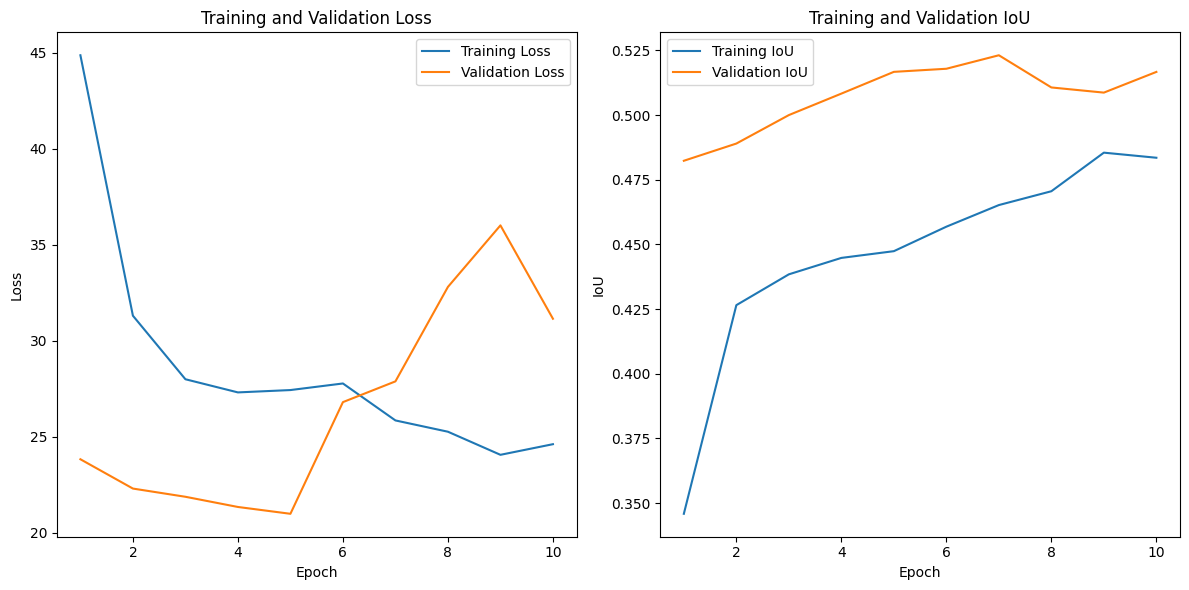

Epoch 10, Train Loss: 24.602868645279496, Train IoU: 0.48347665148752705, Val Loss: 31.140457017081125, Val IoU: 0.516659520921253
Epoch: 10


epoch 10 L  35.127033 average_iou 0.381577: 100%|██████████| 81/81 [01:52<00:00,  1.39s/it]


Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] 

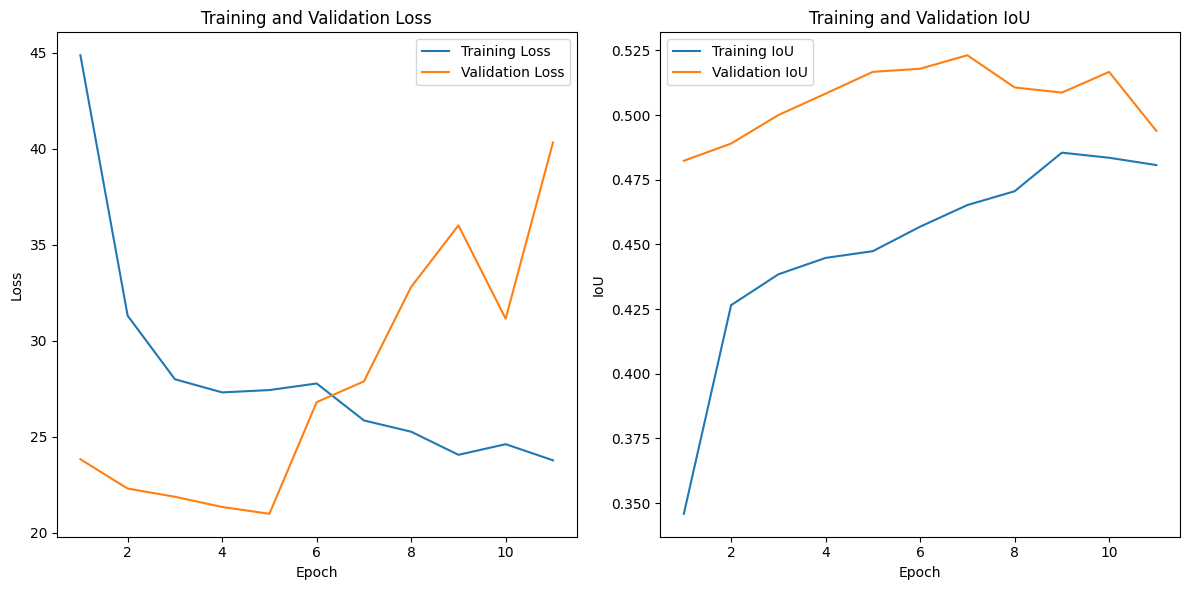

Epoch 11, Train Loss: 23.76312759776174, Train IoU: 0.48064177437329, Val Loss: 40.31977721623012, Val IoU: 0.49385994530859445
Epoch: 11


epoch 11 L  35.387196 average_iou 0.366375: 100%|██████████| 81/81 [01:54<00:00,  1.41s/it]


Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] 

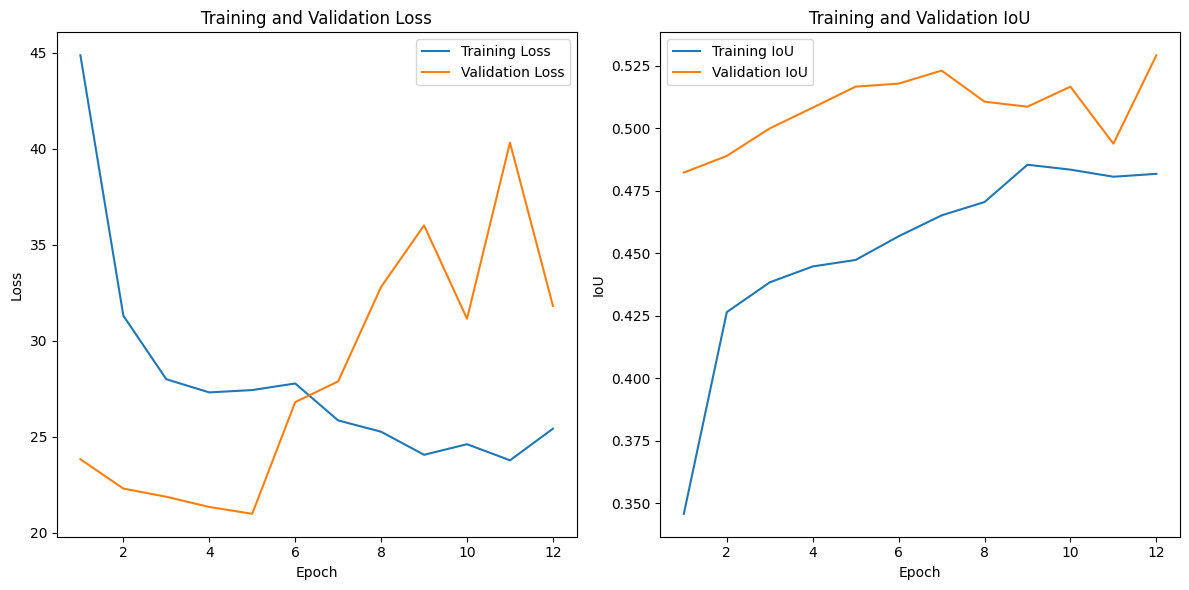

Epoch 12, Train Loss: 25.409924813258794, Train IoU: 0.4817981447702573, Val Loss: 31.810736792428152, Val IoU: 0.5292224742117382
Epoch: 12


epoch 12 L  34.568428 average_iou 0.374017: 100%|██████████| 81/81 [01:56<00:00,  1.44s/it]


Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] 

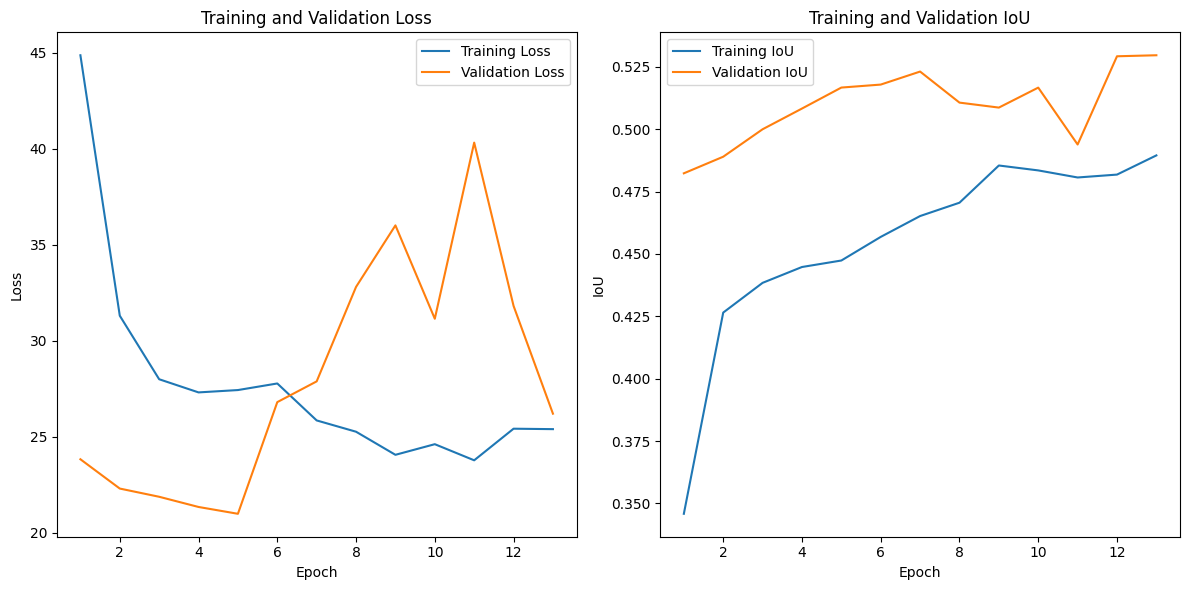

Epoch 13, Train Loss: 25.387065534238463, Train IoU: 0.4894915136658115, Val Loss: 26.193462962195987, Val IoU: 0.5296302948679242
Epoch: 13


epoch 13 L  37.076744 average_iou 0.366242: 100%|██████████| 81/81 [02:14<00:00,  1.67s/it]


Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] 

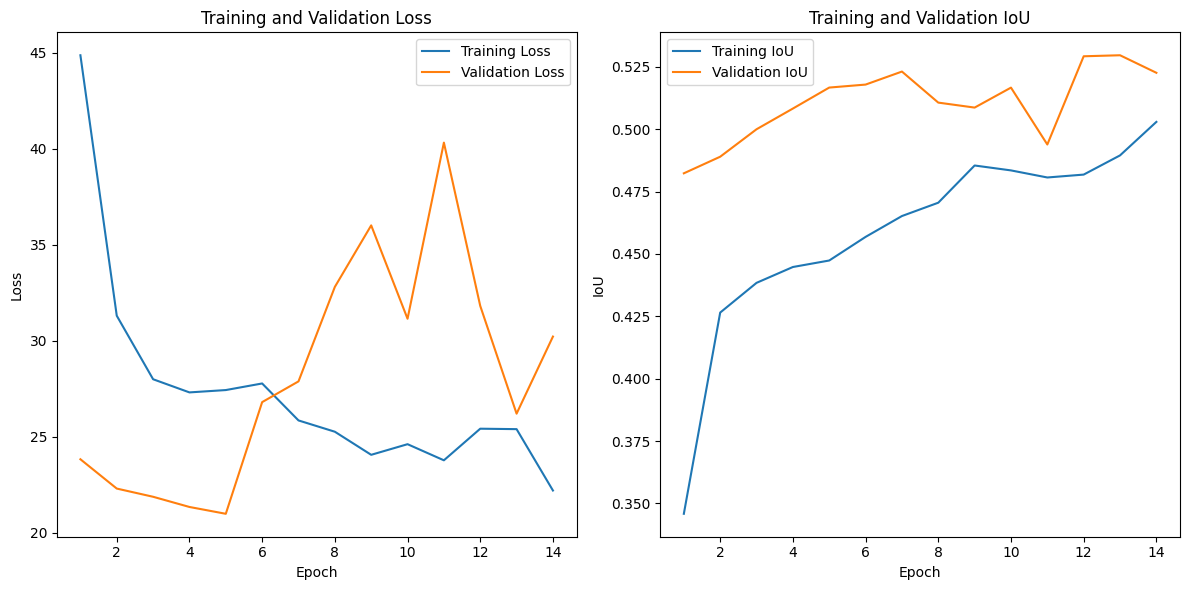

Epoch 14, Train Loss: 22.189084900750053, Train IoU: 0.5029204149305084, Val Loss: 30.211367198399135, Val IoU: 0.5226044484547206
Epoch: 14


epoch 14 L  35.292274 average_iou 0.374241: 100%|██████████| 81/81 [01:58<00:00,  1.47s/it]


Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] 

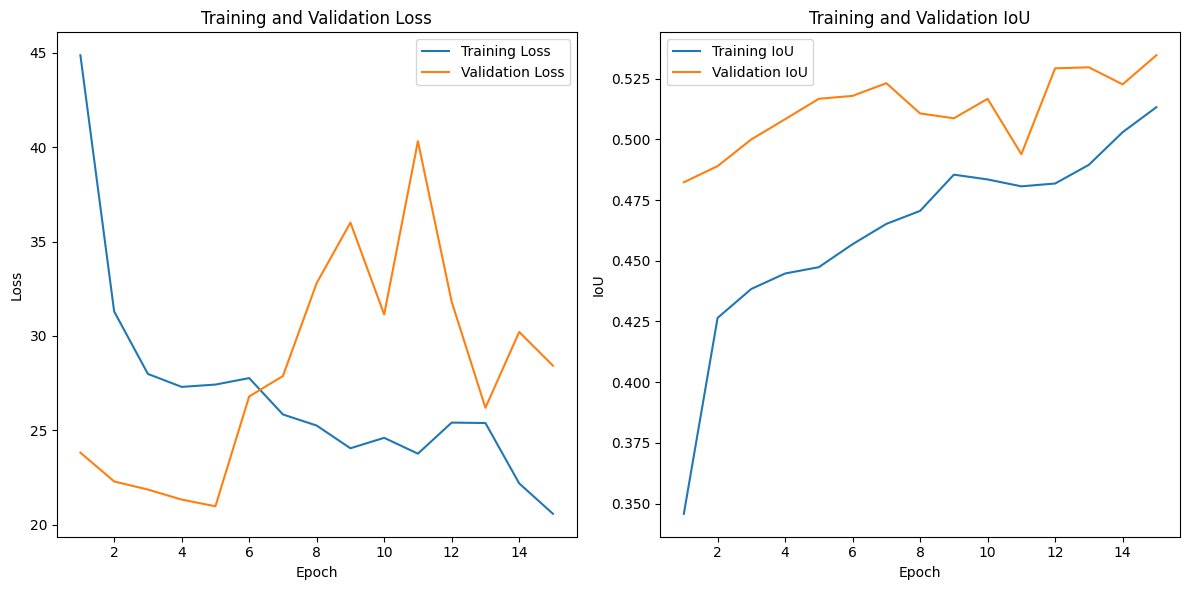

Epoch 15, Train Loss: 20.577716568369926, Train IoU: 0.5132124755117629, Val Loss: 28.428844588143484, Val IoU: 0.5345969583306994
Epoch: 15


epoch 15 L  34.812260 average_iou 0.381314: 100%|██████████| 81/81 [02:04<00:00,  1.54s/it]


Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] 

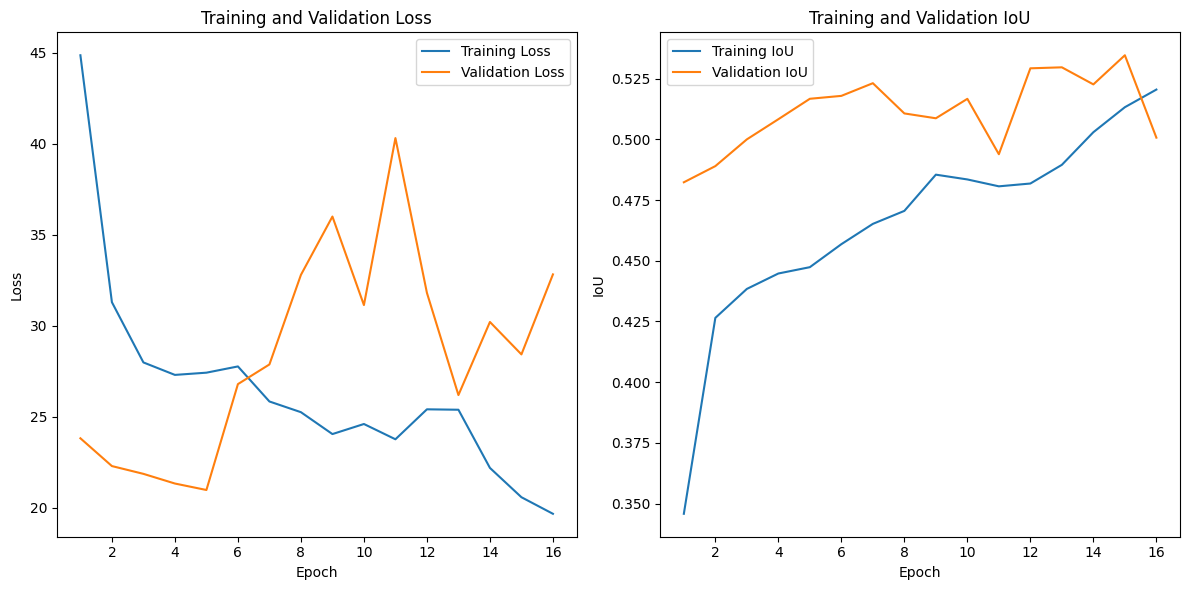

Epoch 16, Train Loss: 19.666986383037802, Train IoU: 0.5204720265335507, Val Loss: 32.82674816676548, Val IoU: 0.500681642975126
Epoch: 16


epoch 16 L  33.909554 average_iou 0.407861: 100%|██████████| 81/81 [01:54<00:00,  1.41s/it]


Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] 

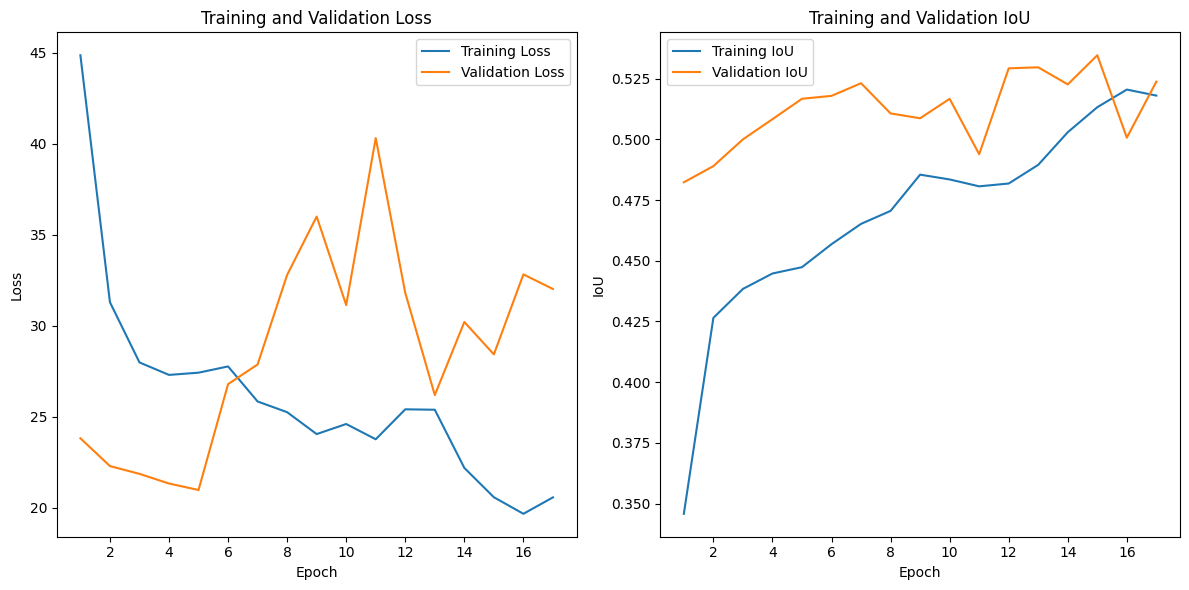

Epoch 17, Train Loss: 20.56921618073075, Train IoU: 0.5179953071070306, Val Loss: 32.02424385434105, Val IoU: 0.523756130820229
Epoch: 17


epoch 17 L  31.708979 average_iou 0.407229: 100%|██████████| 81/81 [01:57<00:00,  1.45s/it]


Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] 

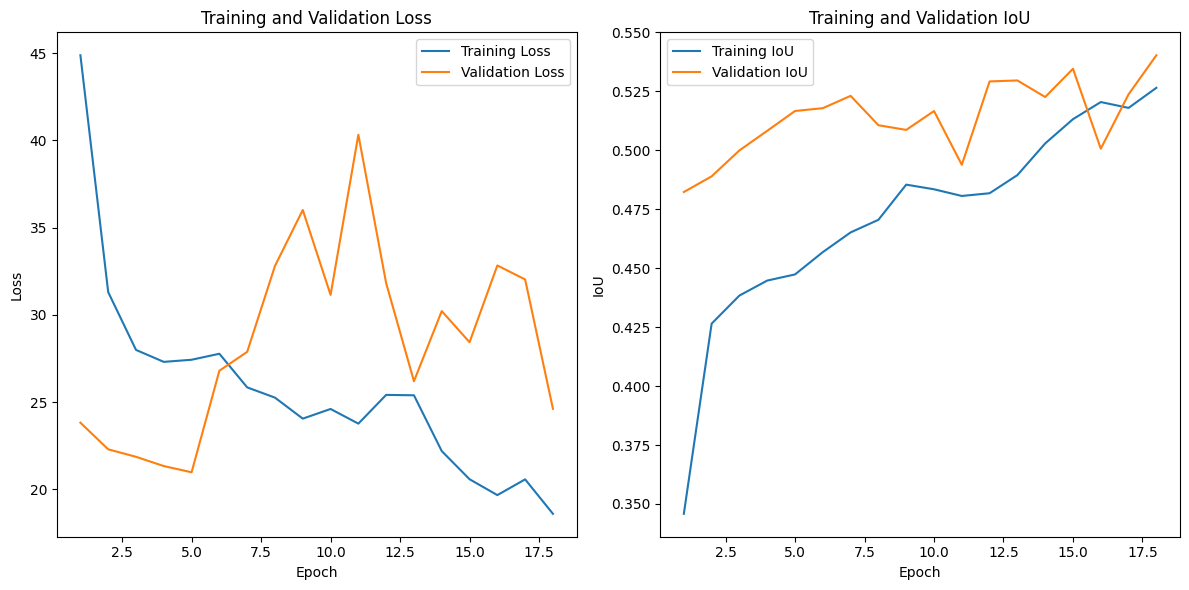

Epoch 18, Train Loss: 18.596348262127535, Train IoU: 0.5265156852978247, Val Loss: 24.61307189578102, Val IoU: 0.5403184919130235
Epoch: 18


epoch 18 L  38.633167 average_iou 0.411104: 100%|██████████| 81/81 [01:57<00:00,  1.45s/it]


Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] 

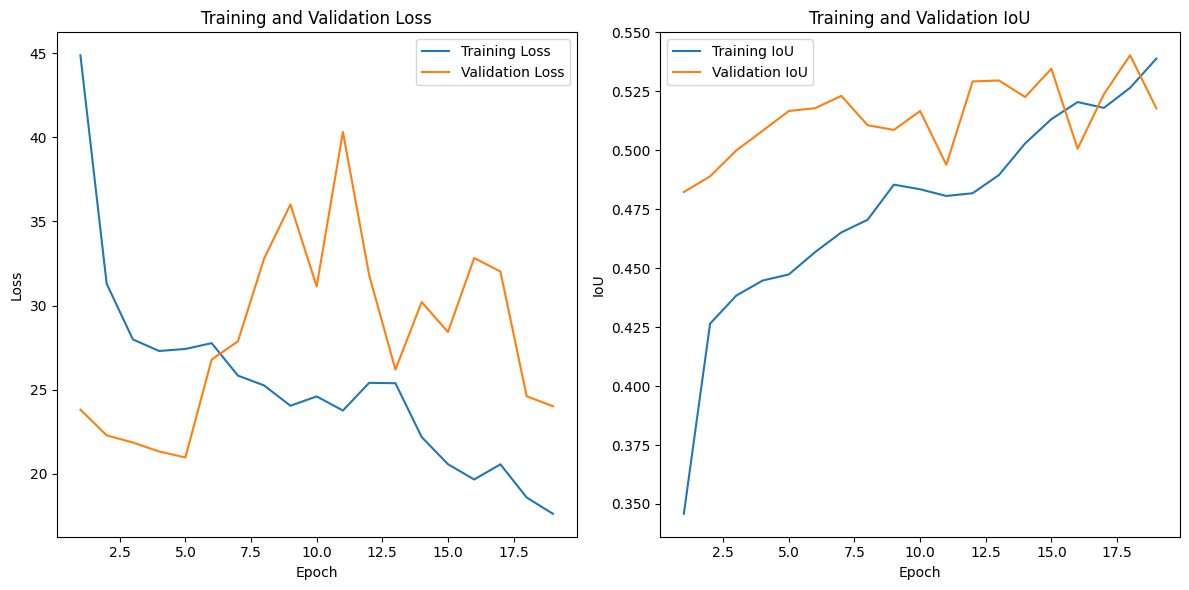

Epoch 19, Train Loss: 17.629132677007604, Train IoU: 0.5388909920498177, Val Loss: 24.02069514138358, Val IoU: 0.517795918952851
Epoch: 19


epoch 19 L  31.920385 average_iou 0.481364: 100%|██████████| 81/81 [01:57<00:00,  1.45s/it]


Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] 

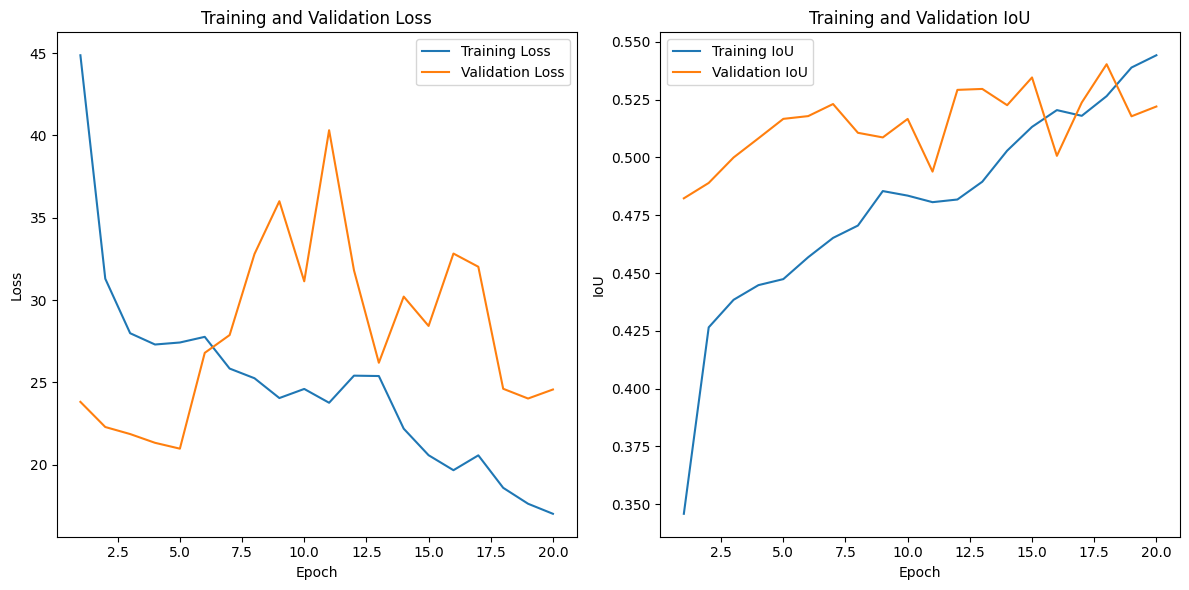

Epoch 20, Train Loss: 17.01865048467377, Train IoU: 0.5441966513056814, Val Loss: 24.56911141531808, Val IoU: 0.5220260648500352
Epoch: 20


epoch 20 L  27.950115 average_iou 0.521718: 100%|██████████| 81/81 [01:58<00:00,  1.46s/it]


Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] 

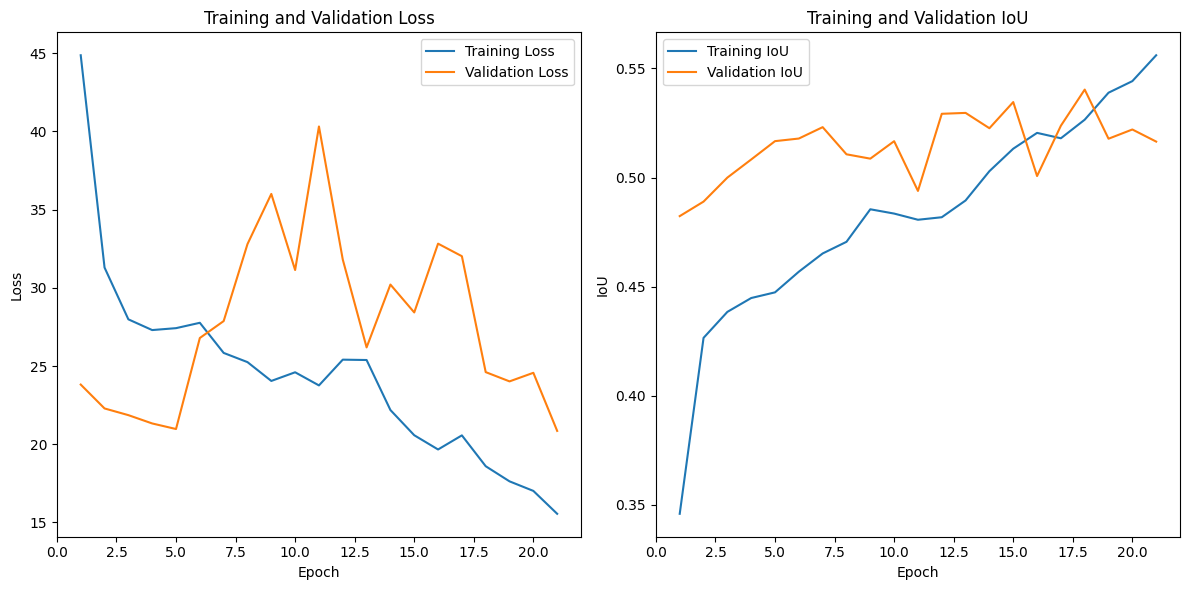

Epoch 21, Train Loss: 15.55487252459114, Train IoU: 0.5560570727159948, Val Loss: 20.854427973429363, Val IoU: 0.5164735856510344
Epoch: 21


epoch 21 L  25.222418 average_iou 0.521003: 100%|██████████| 81/81 [01:59<00:00,  1.47s/it]


Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] 

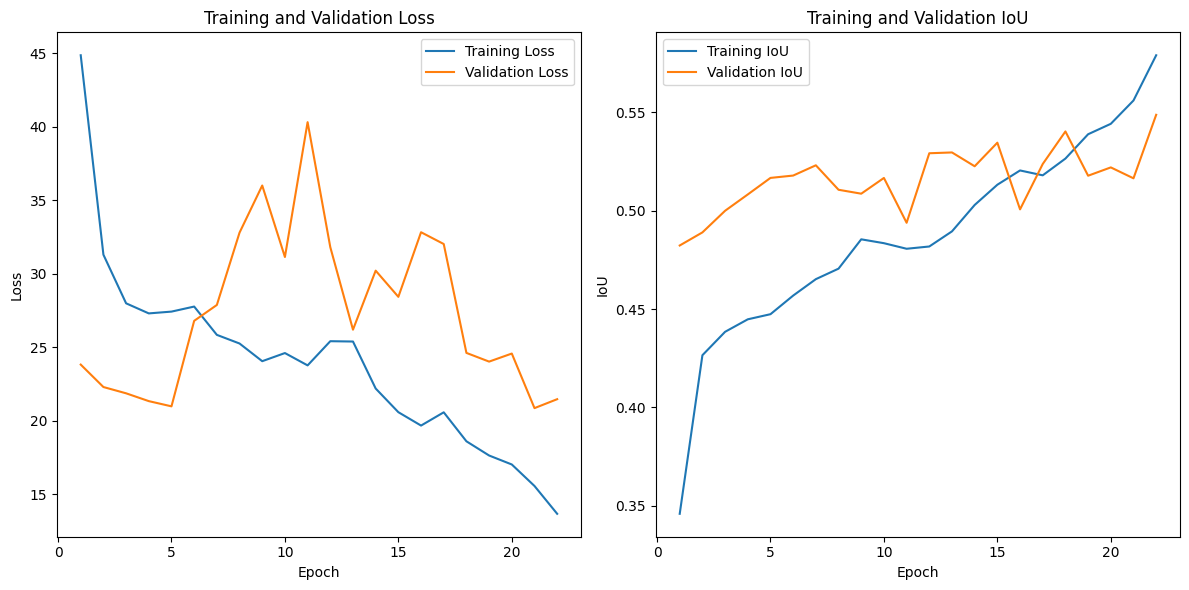

Epoch 22, Train Loss: 13.661900638062278, Train IoU: 0.5790633003652832, Val Loss: 21.46271546681722, Val IoU: 0.548775736774717
Epoch: 22


epoch 22 L  26.602844 average_iou 0.540534: 100%|██████████| 81/81 [01:58<00:00,  1.46s/it]


Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] 

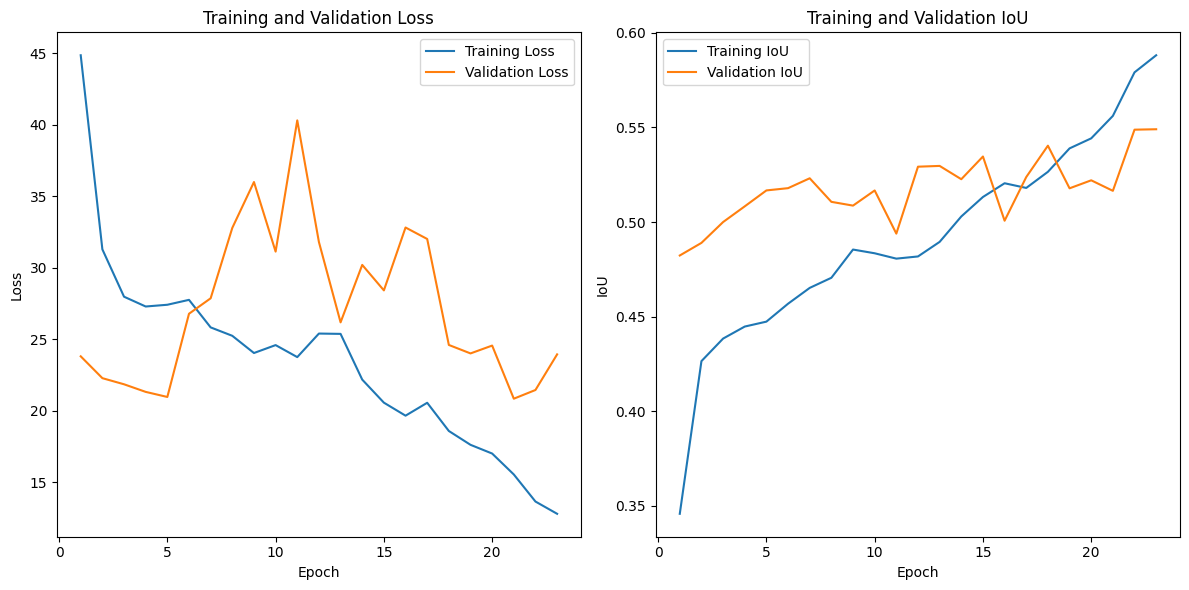

Epoch 23, Train Loss: 12.805088696656403, Train IoU: 0.588092025047467, Val Loss: 23.95396514165969, Val IoU: 0.549001890988577
Epoch: 23


epoch 23 L  23.997366 average_iou 0.568590: 100%|██████████| 81/81 [02:01<00:00,  1.50s/it]


Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] 

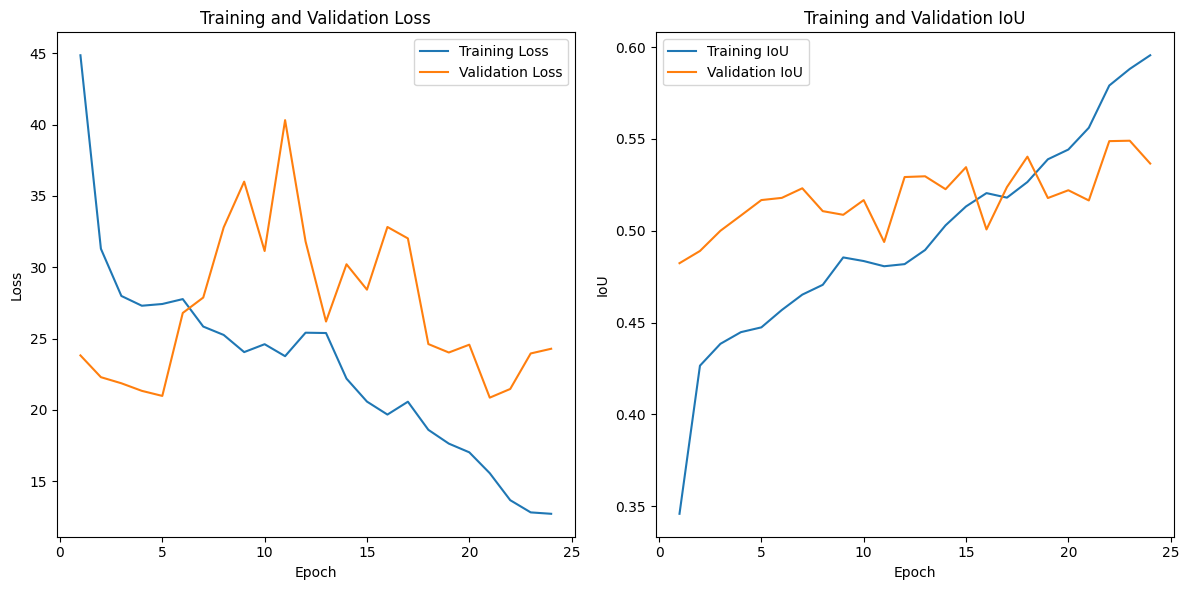

Epoch 24, Train Loss: 12.706434479466191, Train IoU: 0.5955376374868699, Val Loss: 24.283296539669944, Val IoU: 0.5365625307673499
Epoch: 24


epoch 24 L  27.354944 average_iou 0.492371: 100%|██████████| 81/81 [01:55<00:00,  1.42s/it]


Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] 

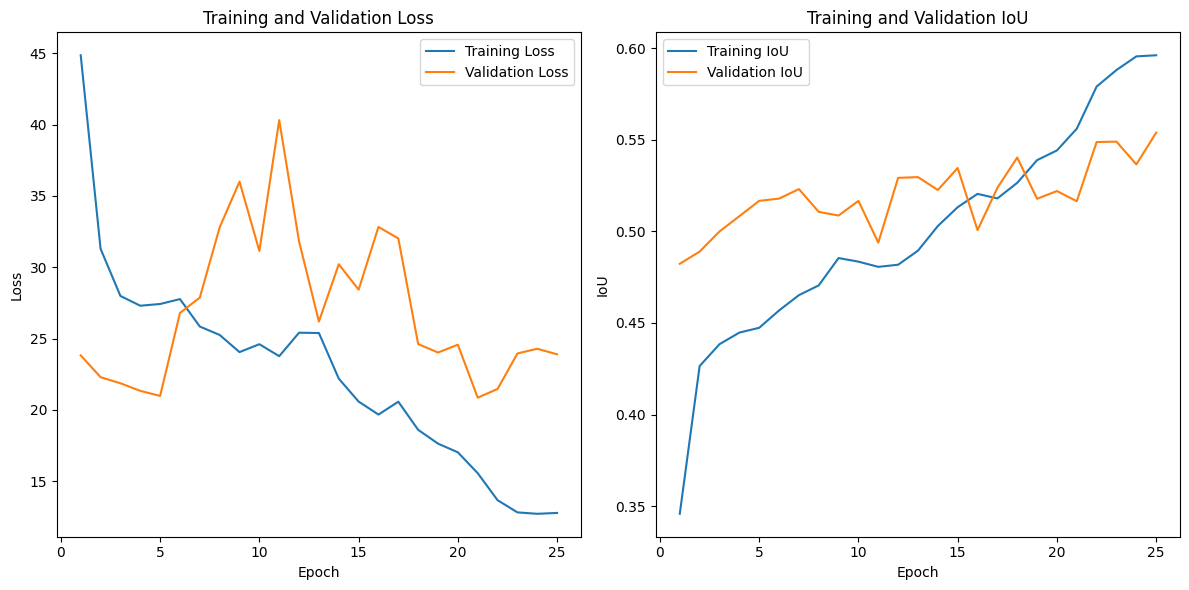

Epoch 25, Train Loss: 12.766511852358594, Train IoU: 0.5961476678465619, Val Loss: 23.892722084408714, Val IoU: 0.5538952024210066
Epoch: 25


epoch 25 L  23.739857 average_iou 0.562326: 100%|██████████| 81/81 [01:57<00:00,  1.45s/it]


Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] 

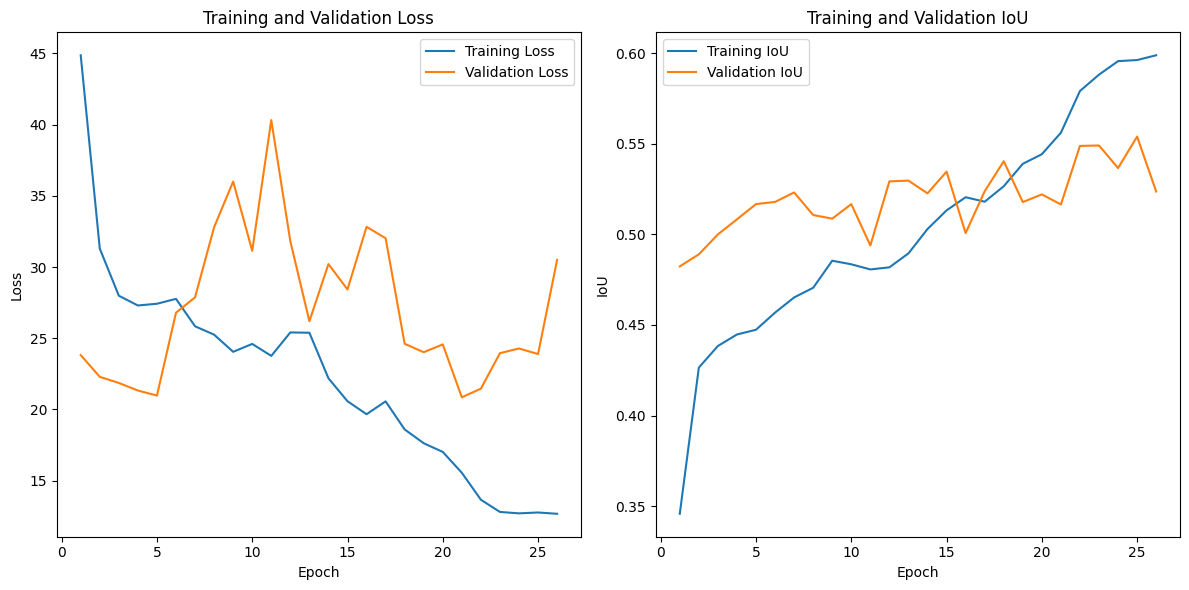

Epoch 26, Train Loss: 12.674887786676853, Train IoU: 0.5987839253596318, Val Loss: 30.50584229968843, Val IoU: 0.5236111198152814
Epoch: 26


epoch 26 L  24.657732 average_iou 0.568961: 100%|██████████| 81/81 [01:55<00:00,  1.43s/it]


Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] 

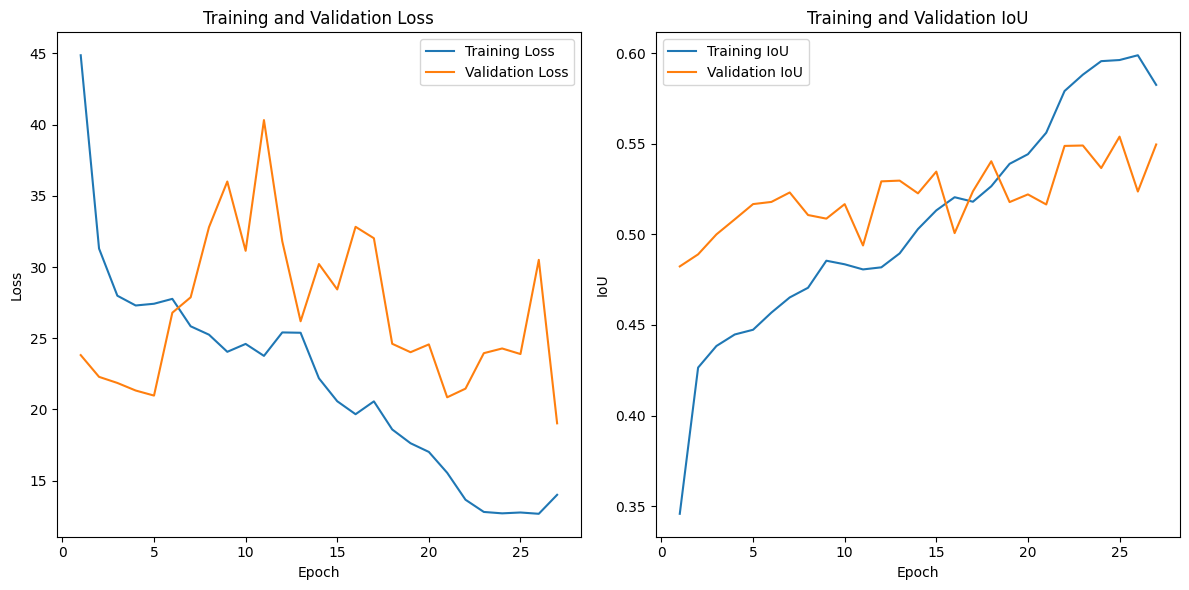

Epoch 27, Train Loss: 14.007290751845748, Train IoU: 0.5824436067063131, Val Loss: 19.026592027573358, Val IoU: 0.5495706796646118
Epoch: 27


epoch 27 L  31.915668 average_iou 0.467905: 100%|██████████| 81/81 [01:53<00:00,  1.40s/it]


Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] 

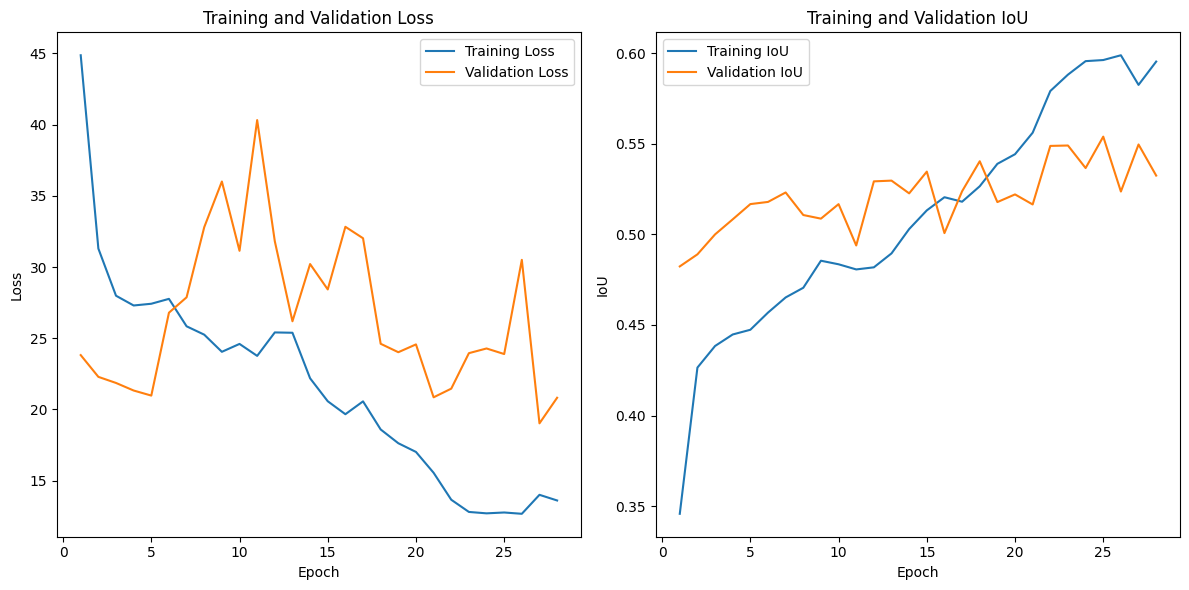

Epoch 28, Train Loss: 13.609929732334466, Train IoU: 0.5952987350799419, Val Loss: 20.822830926804315, Val IoU: 0.5324120095797947
Epoch: 28


epoch 28 L  31.842541 average_iou 0.512402: 100%|██████████| 81/81 [01:53<00:00,  1.40s/it]


Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] 

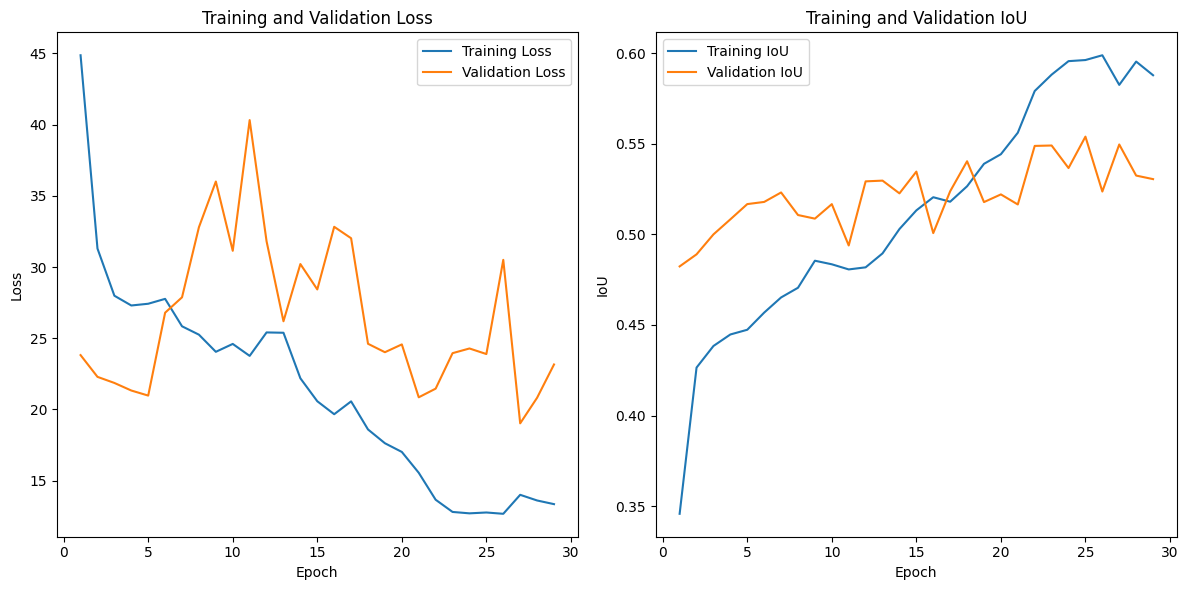

Epoch 29, Train Loss: 13.352496041191948, Train IoU: 0.5877641869915856, Val Loss: 23.15944085802351, Val IoU: 0.5304564379510426
Epoch: 29


epoch 29 L  23.657015 average_iou 0.553907: 100%|██████████| 81/81 [01:50<00:00,  1.37s/it]


Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] at index 1 does not match the shape of the indexed tensor [64, 7, 5] at index 1
Error processing bboxes: The shape of the mask [64, 5] 

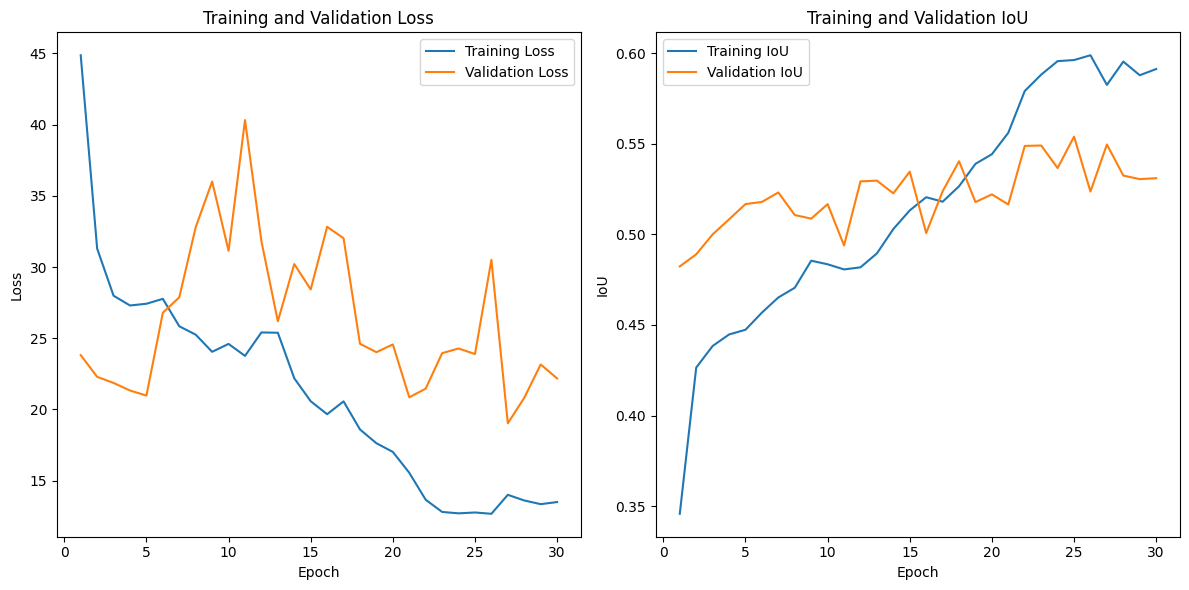

Epoch 30, Train Loss: 13.498979792182828, Train IoU: 0.5911938676863541, Val Loss: 22.181907199677966, Val IoU: 0.5309620343503498


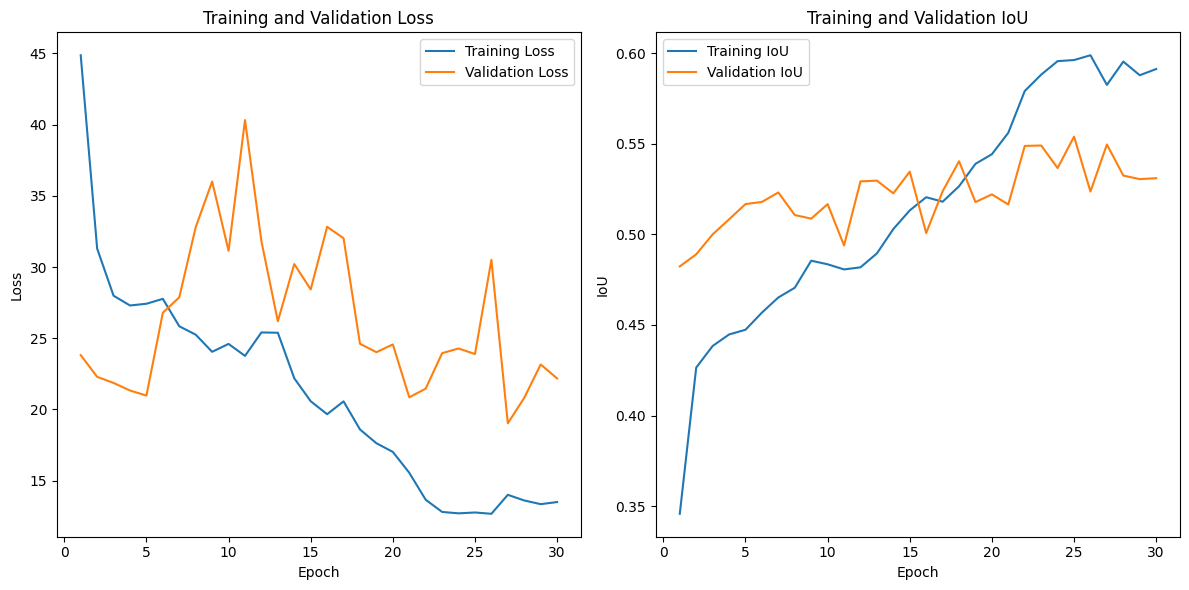

In [51]:

import time
from tqdm import tqdm
confidence_threshold = 0.50  # Порог уверенности для демонстрации
last_confident_bbox = None  # Для хранения последнего уверенного bounding box

train_losses, val_losses, train_ious, val_ious = [], [], [], []

num_epochs = 30
image_width, image_height = 224, 224  # Примерные размеры изображения, измените на ваши
best_val_loss = float('inf')
for epoch in range(num_epochs):
    model.train()
    train_mse, train_iou_accum = 0, 0
    print(f'Epoch: {epoch}')
    pbar = tqdm(train_loader)
    #epoch_start = time.time()
    #previous_loop_end_time = time.time()
    for batch_idx, (images, targets) in enumerate(pbar):
        #for_line_time = time.time() - previous_loop_end_time
        #load_time_start = time.time()

        
        if torch.cuda.is_available():
            images, targets = images.cuda(), targets.cuda()
        
        #load_time = time.time() - load_time_start
        
        #process_start = time.time()
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, targets)  # Считаем потери для каждого временного шага
        
        loss.backward()  # Обратное распространение ошибки
        
        train_mse += loss.item()
        cur_mse = loss.item()
        #backward_start = time.time()
        optimizer.step()
        # backward_time = time.time() - backward_start
        
        #detach_start = time.time()
        outputs = outputs.detach().cpu()
        targets = targets.detach().cpu()
        #detach_time = time.time() - detach_start
        
        #iou_start = time.time()
        predicted_corners = convert_yolo_to_corners(outputs, image_width, image_height)
        target_corners = convert_yolo_to_corners(targets.squeeze(), image_width, image_height)
        
        iou_scores = compute_iou_batch(predicted_corners, target_corners)
        average_iou = iou_scores.mean().item()
        train_iou_accum += average_iou
        #iou_time = time.time() - iou_start
        
        #total_time = time.time() - process_start
        #print(f'Batch {batch_idx} processed in {total_time:.2f}s (Load: {load_time:.2f}s, Backward: {backward_time:.2f}s, Detach: {detach_time:.2f}s, IoU: {iou_time:.2f}s, For Loop line took: {for_line_time:.2f}s)')
        
        #previous_loop_end_time = time.time()
        pbar.set_description("epoch %d L  %f average_iou %f"
                                 % (epoch, cur_mse, average_iou))
    #epoch_time = time.time() - epoch_start
    #print(f'Epoch {epoch} completed in {epoch_time:.2f}s')

    average_train_mse = train_mse / len(train_loader)
    average_train_iou = train_iou_accum / len(train_loader)
    train_losses.append(average_train_mse)
    train_ious.append(average_train_iou)

    model.eval()
    val_mse, val_iou_accum = 0, 0
    with torch.no_grad():
        
        for batch_idx, (images, targets) in enumerate(test_loader):
            if torch.cuda.is_available():
                images, targets = images.cuda(), targets.cuda()

            outputs = model(images)
            confidences, bboxes = get_confidence_and_bbox(outputs)

            try:
                mask = confidences >= confidence_threshold
                if last_confident_bbox is not None and (~mask).any():
                    bboxes[~mask, :] = last_confident_bbox

                if mask.any():
                    last_confident_bbox = bboxes[mask][-1]
            except IndexError as e:
                print(f"Error processing bboxes: {str(e)}")

            loss = criterion(outputs, targets)
            val_mse += loss.item()

            predicted_corners = convert_yolo_to_corners(bboxes, image_width, image_height)
            target_corners = convert_yolo_to_corners(targets.squeeze(), image_width, image_height)
            iou_scores = compute_iou_batch(predicted_corners, target_corners)
            val_iou_accum += iou_scores.mean().item()


    average_val_loss = val_mse / len(test_loader)
    average_val_iou = val_iou_accum / len(test_loader)
    val_losses.append(average_val_loss)
    val_ious.append(average_val_iou)
    
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss': best_val_loss,
        }, filename=f"best_model_epoch_{epoch+1}.pth")

    # Отрисовка графиков
    plot_metrics(train_losses, val_losses, train_ious, val_ious, epoch)

    print(f"Epoch {epoch + 1}, Train Loss: {average_train_mse}, Train IoU: {average_train_iou}, Val Loss: {average_val_loss}, Val IoU: {average_val_iou}")

# Визуализация потерь и IoU
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_ious, label='Training IoU')
plt.plot(epochs, val_ious, label='Validation IoU')
plt.title('Training and Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

plt.tight_layout()
plt.show()

In [52]:
def convert_model_output_to_boxes(outputs, img_width=224, img_height=224):
    """
    Конвертирует выходные данные модели из формата YOLO в координаты bounding boxes.
    
    Параметры:
    outputs (torch.Tensor): Тензор размером [batch_size, num_boxes, 5]
                            где каждый элемент box состоит из [confidence, x_center, y_center, width, height]
    img_width (int): Ширина изображения
    img_height (int): Высота изображения
    
    Возвращает:
    list of list of tuples: Список списков с координатами боксов для каждого изображения в батче
                            в формате [(x1, y1, width, height), ...]
    """
    batch_size = outputs.shape[0]
    all_boxes = []
    for i in range(batch_size):
        boxes = []
        for box in outputs[i]:
            if box[0] > 0.5:  # Порог уверенности
                # Масштабирование координат относительно размеров изображения
                x_center = box[1] * img_width
                y_center = box[2] * img_height
                width = box[3] * img_width
                height = box[4] * img_height

                # Преобразование из центральных координат в координаты верхнего левого угла
                x1 = x_center - width / 2
                y1 = y_center - height / 2

                boxes.append((x1, y1, width, height))
        all_boxes.append(boxes)
    return all_boxes


torch.Size([1, 8, 3, 224, 224])
torch.Size([1, 8, 5])
1


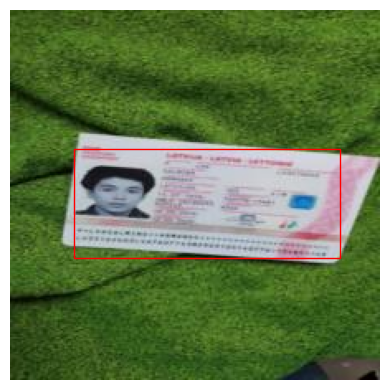

In [53]:
if torch.cuda.is_available():
    model = model.cuda()
model.eval()

def plot_predictions(batch_images, pred_boxes):
    """Функция для отрисовки изображений с предсказанными bounding boxes."""
    fig, axs = plt.subplots(nrows=1, ncols=len(batch_images), figsize=(20, 4))  # Увеличенный размер для лучшей визуализации
    if len(batch_images) == 1:
        axs = [axs]  # Обеспечиваем работу с одним изображением

    for i, ax in enumerate(axs):
        img = batch_images[0][i].permute(1, 2, 0).cpu().numpy()  # Перемещаем на CPU и преобразуем в numpy
        ax.imshow(img)
        ax.axis('off')

        # Получение предсказаний для текущего изображения
        # Убедитесь, что предсказания соответствуют i-му изображению
        if len(pred_boxes[i]) > 0:  # Проверка наличия предсказаний для изображения
            box = pred_boxes[i][0]  # Получаем первый бокс, предполагая, что нужен только один
            x, y, w, h = box
            rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

    plt.tight_layout()
    plt.show()



for images, _ in loader:
    if torch.cuda.is_available():
        images = images.cuda()
        print(images.shape)

    with torch.no_grad():
        outputs = model(images)
        print(outputs.shape)
        outputs = outputs.cpu()  # Перемещаем на CPU
        # Преобразование выходных данных модели в формат координат боксов
        pred_boxes = convert_model_output_to_boxes(outputs, image_width, image_height)  # Убедитесь в правильности аргументов
    print(len(pred_boxes))
    plot_predictions(images.cpu(), pred_boxes)
    break  # Пример с одним батчем для демонстрации

8
Rectangle(xy=(41.1936, 59.4936), width=162.717, height=70.2759, angle=0)
8
Rectangle(xy=(52.3947, 78.6355), width=130.596, height=58.7528, angle=0)
8
Rectangle(xy=(39.4086, 63.0036), width=163.099, height=69.1308, angle=0)
8
Rectangle(xy=(45.623, 74.7844), width=142.446, height=61.3984, angle=0)
8
Rectangle(xy=(38.1943, 79.3467), width=160.423, height=65.4955, angle=0)
8
Rectangle(xy=(38.2368, 83.526), width=160.694, height=65.3704, angle=0)
8
Rectangle(xy=(41.0882, 83.1674), width=152.518, height=64.7369, angle=0)
8
Rectangle(xy=(56.8623, 82.7578), width=132.324, height=61.8561, angle=0)


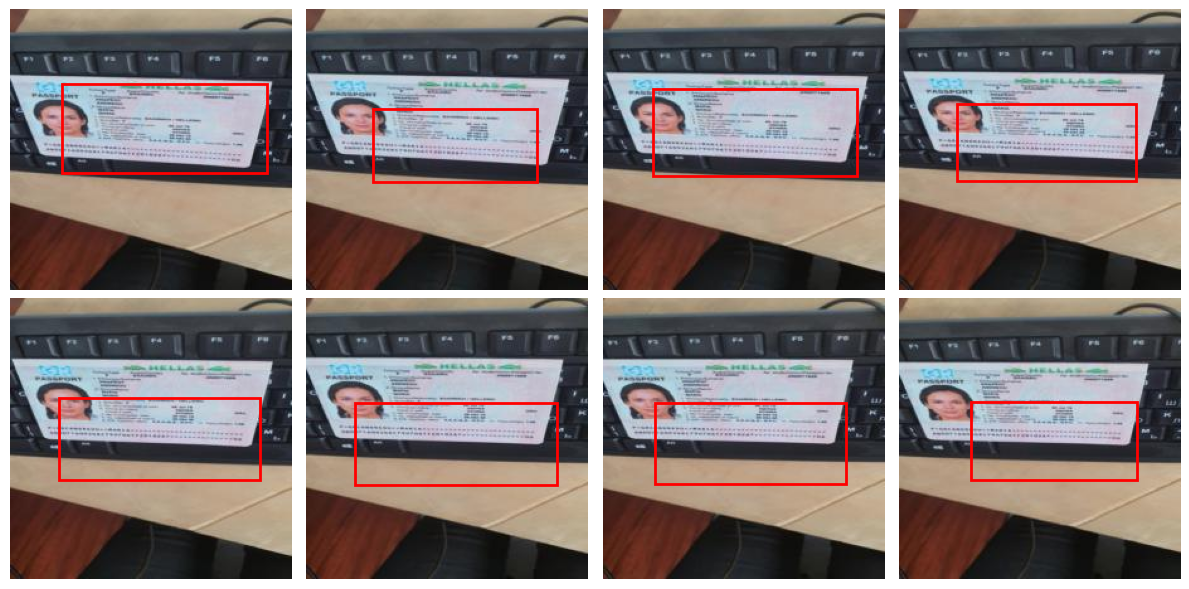

In [54]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Импорт модели и датасета, установка трансформаций
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset = YourDataset(img_dir, ann_dir, transform=transform)
loader = DataLoader(dataset, batch_size=8, shuffle=True)

# Проверка доступности GPU и перенос модели на GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def plot_images(batch_images, batch_boxes):
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
    axs = axs.flatten()
    
    for i in range(len(batch_images)):
        img = batch_images[0][i].permute(1, 2, 0).detach().cpu().numpy()
        img = (img * 255).astype(np.uint8)
        ax = axs[i]
        ax.imshow(img)
        
        bboxes = batch_boxes[i].detach().cpu()
        print(len(bboxes))
        # for box in bboxes:
            # Получаем абсолютные пиксельные координаты для bboxes
        x_center, y_center, width, height = bboxes[0][1:5]
        x = (x_center - width / 2) * img.shape[1]
        y = (y_center - height / 2) * img.shape[0]
        width = width * img.shape[1]
        height = height * img.shape[0]
            
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
        print(rect)
        ax.add_patch(rect)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


for batch_images, _ in loader:
    batch_images = batch_images.to(device)
    predicted_boxes = model(batch_images)
    
    plot_images(batch_images, predicted_boxes)

    break  # Остановка после одного батча для демонстрации